# 8. Análisis de tópicos dinámicos

## 1. Motivación

El __análisis de tópicos dinámicos__ permite descubrir, a partir de los propios textos, el conjunto de tópicos que estos abordan. A diferencia del análisis de tópicos simple, permite también descubrir cómo los tópicos evolucionan en el tiempo.

Por ejemplo, suponiendo que tenemos un conjunto de articulos cíentificos en el ámbito de la Física, escritos entre 1880 y 2000. Podemos aplicar un análisis de tópicos dinámicos para encontrar de qué topicos se hablan y descubrir que uno de los tópicos tiene que ver con la _Física Atómica_. El análisis de tópicos dinámicos permite descubrir además que, dentro de este tópico, hubo cambios en el lenguaje (ver Figuras).

<img src="img/dtm1.png"/>


<img src="img/dtm2.png"/>

En este ejemplo, los datos están divididos en 13 trozos (_slices_) de 10 años.

## Práctica: _¿Cómo ha evolucionado el discurso sobre el cancer en la prensa chilena entre 2010 y 2020?_

Realizaremos un análisis de tópicos dinámicos sobre un dataset de noticias chilenas que contienen las palabras cancer, oncologico, oncologia, linfome, leucemia.


## 2. Leer el dataset original

In [1]:
dataset="data/cancer_oncologico_oncologia_linfome_leucemia.csv"

In [2]:
import pandas as pd
df = pd.read_csv(dataset)
df[:5]

,Unnamed: 0,Unnamed: 0.1,id_news,country,media_outlet,url,title,text,date,search
0,0,0,6379315.0,chile,elciudadano,https://www.elciudadano.com/salud/1sintomas-de...,Síntomas del cáncer que la mayoría de personas...,BBC Mundo ha recogido los 10 síntomas general...,2016-04-29,cáncer
1,3,3,1450993.0,chile,biobiochile,https://www.biobiochile.cl/noticias/2014/12/29...,12 señales de que podrías estar albergando un ...,"El cáncer es un grupo de varias enfermedades, ...",2014-12-29,cáncer
2,4,4,6415265.0,chile,elciudadano,https://www.elciudadano.com/salud/los-sintomas...,Los síntomas físicos que te ayudan a detectar ...,Muchos hombres piensan erróneamente que los sí...,2015-09-15,cáncer
3,6,6,6276346.0,chile,latercera,https://www.latercera.com/tendencias/noticia/c...,Científicos revelan vínculo entre la diabetes ...,"Una reciente aparición de diabetes tipo 2, que...",2018-06-18,cáncer
4,7,7,15573918.0,chile,emol,https://www.emol.com/noticias/Tecnologia/2018/...,Científicos creen que la diabetes podría ser u...,LONDRES.- Una reciente aparición de diabetes t...,2018-06-18,cáncer


In [3]:
print("Número de documentos: "+str(df.count()[0]))

Número de documentos: 7633


In [4]:
duplicated=df[df['url'].duplicated()]
print("Son "+str(len(duplicated))+" noticias duplicadas.")
duplicated

Son 0 noticias duplicadas.


,Unnamed: 0,Unnamed: 0.1,id_news,country,media_outlet,url,title,text,date,search


In [5]:
from pandasql import sqldf

- ¿Cuáles son los medios y su número de noticias?

In [6]:
query="""SELECT media_outlet,count(*) as noticias
FROM df GROUP BY media_outlet ORDER BY noticias DESC;"""
result=sqldf(query)
result

,media_outlet,noticias
0,ahoranoticiasmega,1994
1,elciudadano,1413
2,emol,1161
3,biobiochile,1107
4,latercera,1098
5,horas24,706
6,elmostrador,154


- ¿Cómo se distribuyen las noticias en el tiempo?

In [7]:
#Contar el número de documentos por año

query="""SELECT strftime('%Y', date) as year,count(*) as documents
FROM df GROUP BY year;"""
result=sqldf(query)
result

,year,documents
0,2010,52
1,2011,104
2,2012,210
3,2013,339
4,2014,406
5,2015,750
6,2016,834
7,2017,963
8,2018,1254
9,2019,1393


Construiremos un dataset con 10 trozos de 150 noticias (2010-11, 2012, 2013, 2014, ..., 2020).

## 3. Construir un dataset con sus distintos trozos

In [8]:
years = ["2020","2019","2018","2017","2016","2015","2014","2013","2012"]

df_list=[]

for year in years:
    query="SELECT * FROM df WHERE strftime('%Y', date) = \""+year+"\";"
    result=sqldf(query)
    result=result.sample(n = 150)
    df_list.append(result)
    

query="SELECT * FROM df WHERE strftime('%Y', date) = \"2011\" OR strftime('%Y', date) = \"2010\";"
result=sqldf(query)
result=result.sample(n = 150)
df_list.append(result)

df_final=pd.concat(df_list)

In [9]:
query="SELECT * FROM df_final ORDER BY date ASC;"
result=sqldf(query)
df=result

In [10]:
#Contar el número de documentos por año

query="""SELECT strftime('%Y', date) as year,count(*) as documents
FROM df GROUP BY year;"""
result=sqldf(query)
result

,year,documents
0,2010,49
1,2011,101
2,2012,150
3,2013,150
4,2014,150
5,2015,150
6,2016,150
7,2017,150
8,2018,150
9,2019,150


- Para identificar los _slices_, conservamos el número de documentos por cada segmento:

In [11]:
index_slices=[150,150,150,150,150,150,150,150,150,150]

## 4. Preprocesamientos de las noticias

In [12]:
import spacy
nlp = spacy.load('es_core_news_md', disable=['parser','ner','textcat','...'] )

In [13]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [14]:
def getKeywords(dataFrame,columnName):
    
    for index,rows in dataFrame.iterrows():
        
        text=rows[columnName]
        
        filteredText=""
        
        tokens = nlp(text)
        
        for token in tokens:
            if token.pos_ == "NOUN" :
                filteredText=filteredText+","+str(token.text.lower().strip())
                
        matches = matcher(tokens)
        for mach_id, start, end in matches:
            span = tokens[start:end]
            filteredText=filteredText+","+str(span.text.lower().strip())
                
        dataFrame.loc[index,'keywords']=filteredText

In [15]:
%%time
getKeywords(df,"text")

CPU times: user 46.6 s, sys: 776 ms, total: 47.3 s
Wall time: 47.6 s


In [16]:
len(df)

1500

In [17]:
df["keywords"][0]

',gobierno,tercio,reservas,costo,millones,euros,diputado,millones,dosis,gripe,laboratorios,tercio,mundo,presiones,laboratorios,lunes,diputado,partido,gobernante,tercio,farmacias,vacunas,diputado,radio,julio,presión,laboratorios,tiempo,principio,precaución,extremo,profesor,medicina,costo,adquisición,déficit,hospitales,veces,plan,lucha,cáncer,millones,dosis,gripe,mes,julio,millones,euros,millones,dólares,ministerio,reventa,vacunas,dosis,vacuna,autoridades,galas,compra,parte,transnacionales,fabricación,medicinas,agosto,industria,ganancia,millones,dólares,domingo,gobierno,países,reservas,vacunas,virus,gripe,carga,factura,pandemia,anuncio,reventa,medicinas,laboratorio,división,vacunas,grupo,domingo,disposición,demanda,renegociación,contrato,compra,dosis,vacunas,gobierno,julio,despliegue,cabo,pandemia,miedo,compras,dosis,parte,aval,agencia,medicamentos,virus,vez,finales,marzo,fines,diciembre,muertes,mundo,país,cifras,chancho,gobierno galo,reservas mundiales,millones de euros,diputado francés

- Utilizaremos la columna "keywords" como simplificación de los documentos.

In [18]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

documents=list(df['keywords'])
documents=[x.split(",") for x in documents]

dictionary = Dictionary(documents)

#dictionary.filter_extremes(no_below=0,no_above=0.99)

dictionary.filter_n_most_frequent(1)

corpus = [dictionary.doc2bow(doc) for doc in documents] 

model = TfidfModel(corpus)

vectorizedCorpus = model[corpus]

## 5. Optimización de modelos de tópicos dinámicos

Entrenamos modelos con k_topics entre 5 y 12, y guardamos los modelos en archivos.

In [19]:
DTM_models=[]

In [ ]:
%%time
from IPython.display import Audio
import numpy as np

from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.test.utils import datapath

import time

k_topics=5

for i in range(8):
    print(i)
    init=time.time()

    s=time.time()

    ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=index_slices, 
                                 num_topics=k_topics+i,
                                 chain_variance=0.3,
                                 alphas=0.9,
                                 passes=10,
                                 chunksize=24000,
                                 em_min_iter=6,
                                 em_max_iter=15)

    DTM_models.append(ldaseq)

    e=time.time()
    print(str(k_topics+i)+" Topics - Tiempo necesario para la optimización del modelo:",(e-s))

    end=time.time()
    #print(end-init)
    
    #se guarda el modelo
    path_of_model = datapath("/home/mvernier/Documentos/trabajo/docencia/2021/DOCCOM/"+"model_"+str(k_topics+i)+"_topics")
    print(path_of_model)
    ldaseq.save(path_of_model)

0


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


5 Topics - Tiempo necesario para la optimización del modelo: 3308.4403603076935
/home/mvernier/Documentos/trabajo/docencia/2021/DOCCOM/model_5_topics
1


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


6 Topics - Tiempo necesario para la optimización del modelo: 3674.914176464081
/home/mvernier/Documentos/trabajo/docencia/2021/DOCCOM/model_6_topics
2


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


7 Topics - Tiempo necesario para la optimización del modelo: 4791.860530138016
/home/mvernier/Documentos/trabajo/docencia/2021/DOCCOM/model_7_topics
3


/home/mvernier/.local/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


# 4. Evaluación de los modelos

In [116]:
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.test.utils import datapath

PATH="/home/mvernier/Documentos/trabajo/docencia/2021/INFO279_2021/Fundamentos/DTM/models/"

from gensim.models import LdaSeqModel

k_topics=5

model_coherences=list()

for i in range(8):
    path_of_model = datapath(PATH+"model_"+str(k_topics+i)+"_topics")
    ldaseq = LdaSeqModel.load(path_of_model)
    
    coherenceValues=list()
    for time_fragment in range(5):
        topics_wrapper = ldaseq.dtm_coherence(time=time_fragment)
        cm_wrapper_cv = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='c_v')
        coherenceValues.append(cm_wrapper_cv.get_coherence())
    
    averageCoherenceValue = sum(coherenceValues) / len(coherenceValues) 
    model_coherences.append(averageCoherenceValue)

In [117]:
model_coherences

[0.37128090529668584,
 0.3345500833622054,
 0.32682282447305094,
 0.3450158735297677,
 0.33810605082096123,
 0.3222411148702362,
 0.34669298829613354,
 0.3505168102397341]

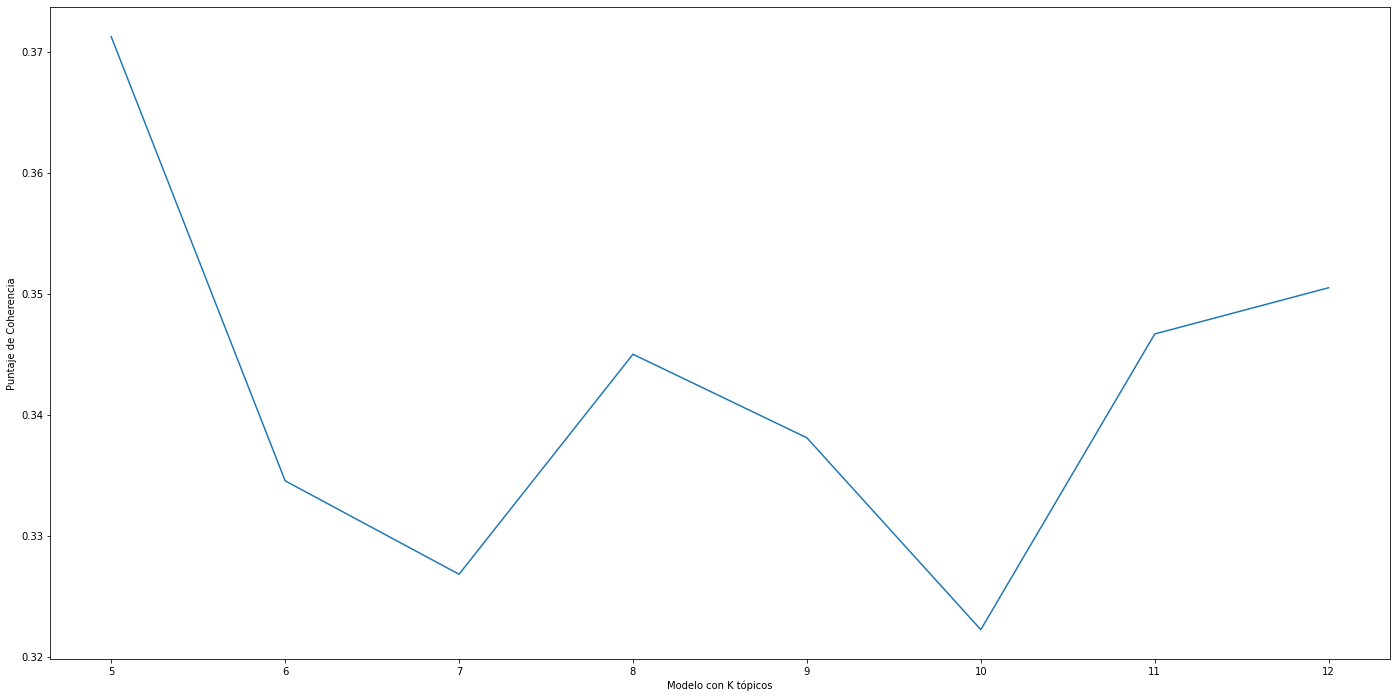

In [118]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np

xvalues=["5","6","7","8","9","10","11","12"]

df_fig1=pd.DataFrame({'xvalues': xvalues, 'yvalues': model_coherences })

fig, ax = plt.subplots()

plt.plot( 'xvalues', 'yvalues', data=df_fig1)
ax.set_xlabel('Modelo con K tópicos')
ax.set_ylabel('Puntaje de Coherencia')
plt.show()

In [119]:
path_of_model = datapath(PATH+"model_"+str(5)+"_topics")
ldaseq = LdaSeqModel.load(path_of_model)

# 5. Análisis de la evolución del discurso

#### 5.1 Tópicos

In [144]:
table=[]
for i in range(5):
    row=["slice "+str(i)]
    keywords=ldaseq.print_topic(topic=4,time=i,top_terms=35)
    for keyword in keywords:
        row.append(str(keyword[0])+", "+str(round(keyword[1],3)))
    table.append(row)

In [145]:
#!pip install tabulate

In [146]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

slice 0,"año, 0.012","personas, 0.008","acuerdo, 0.008","contra, 0.008","través, 0.007","años, 0.007","información, 0.006","casa, 0.006","país, 0.005","hechos, 0.005","parte, 0.005","embargo, 0.005","día, 0.005","medidas, 0.005","meses, 0.004","respecto, 0.004","ministro, 0.004","orden, 0.004","ataques, 0.004","víctima, 0.004","antecedentes, 0.004","declaraciones, 0.004","comuna, 0.004","política, 0.004","sector, 0.004","medicamentos, 0.003","forma, 0.003","frente, 0.003","vez, 0.003","días, 0.003","fiscal, 0.003","seguridad, 0.003","delitos, 0.003","relación, 0.003","caso, 0.003"
slice 1,"año, 0.013","través, 0.011","personas, 0.007","país, 0.007","mercado, 0.006","acuerdo, 0.006","años, 0.006","medicamentos, 0.006","orden, 0.006","forma, 0.006","contra, 0.006","casa, 0.005","día, 0.005","ministro, 0.005","medidas, 0.005","orden público, 0.004","política, 0.004","información, 0.004","vez, 0.004","frente, 0.004","declaraciones, 0.004","caso, 0.004","embargo, 0.004","relación, 0.004","días, 0.004","parte, 0.004","seguridad, 0.003","documentos, 0.003","respecto, 0.003","justicia, 0.003","necesidad, 0.003","ataques, 0.003","precio, 0.003","antecedentes, 0.003","meses, 0.003"
slice 2,"año, 0.016","país, 0.011","través, 0.008","personas, 0.006","ministro, 0.006","ley, 0.006","orden, 0.006","años, 0.005","situación, 0.005","medidas, 0.005","información, 0.005","forma, 0.005","gabinete, 0.005","embargo, 0.005","parte, 0.005","democracia, 0.004","respecto, 0.004","días, 0.004","proyecto, 0.004","acuerdo, 0.004","declaraciones, 0.004","seguridad, 0.004","orden público, 0.004","vez, 0.004","hechos, 0.003","justicia, 0.003","transporte, 0.003","cambio de gabinete, 0.003","caso, 0.003","momento, 0.003","mercado, 0.003","respeto, 0.003","día, 0.003","política, 0.003","frente, 0.003"
slice 3,"país, 0.016","situación, 0.013","medidas, 0.009","días, 0.008","año, 0.008","gabinete, 0.007","años, 0.007","personas, 0.006","ministro, 0.006","forma, 0.005","respecto, 0.005","información, 0.005","cambio de gabinete, 0.004","través, 0.004","transporte, 0.004","niños, 0.004","acuerdo, 0.004","ley, 0.004","parte, 0.004","orden, 0.003","embargo, 0.003","mercado, 0.003","hechos, 0.003","declaraciones, 0.003","medicamentos, 0.003","seguridad, 0.003","proyecto, 0.003","clases, 0.003","vida, 0.003","medio, 0.003","cambio, 0.003","frente, 0.003","justicia, 0.003","palabras, 0.003","caso, 0.003"
slice 4,"país, 0.009","año, 0.009","situación, 0.008","niños, 0.008","información, 0.007","personas, 0.007","forma, 0.005","acuerdo, 0.005","respecto, 0.005","medicamento, 0.005","días, 0.004","años, 0.004","medidas, 0.004","precios, 0.004","inversión, 0.004","través, 0.004","ley, 0.003","lugar, 0.003","abogado, 0.003","países, 0.003","proyecto, 0.003","representante, 0.003","vida, 0.003","justicia, 0.003","mercado, 0.003","sistema, 0.003","adopción, 0.003","cáncer, 0.003","medicamentos, 0.003","parte, 0.003","colegios, 0.003","campaña, 0.003","episodios, 0.003","proyectos, 0.003","matriz, 0.003"


#### Visualizar la evolución de ciertas palabras en un tópico dado

In [147]:
keyword="medidas"
topic=4
xvalues1=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues1=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues1.append(newValue)

('medidas', 0.004593412784264601)
('medidas', 0.004552822006717053)
('medidas', 0.005382439332577652)
('medidas', 0.009274493409711624)
('medidas', 0.004229819390998495)


In [148]:
keyword="abogados"
topic=4
xvalues2=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues2=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues2.append(newValue)

('abogados', 0.00015021210145213385)
('abogados', 0.00014936987358750992)
('abogados', 0.00015102157851952855)
('abogados', 0.00015402135388002092)
('abogados', 0.00015796389005822185)


In [138]:
keyword="crisis"
topic=3
xvalues4=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues4=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues4.append(newValue)

('crisis', 0.0036741838012108647)
('crisis', 0.0038426068398892442)
('crisis', 0.0060718629298637155)
('crisis', 0.003475097734297697)
('crisis', 0.0019707818788194365)


In [139]:
keyword="proyecto"
topic=3
xvalues5=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues5=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues5.append(newValue)

('proyecto', 0.00725566997119499)
('proyecto', 0.00580592381881694)
('proyecto', 0.004781042032067798)
('proyecto', 0.004989277635593654)
('proyecto', 0.006973609771627351)


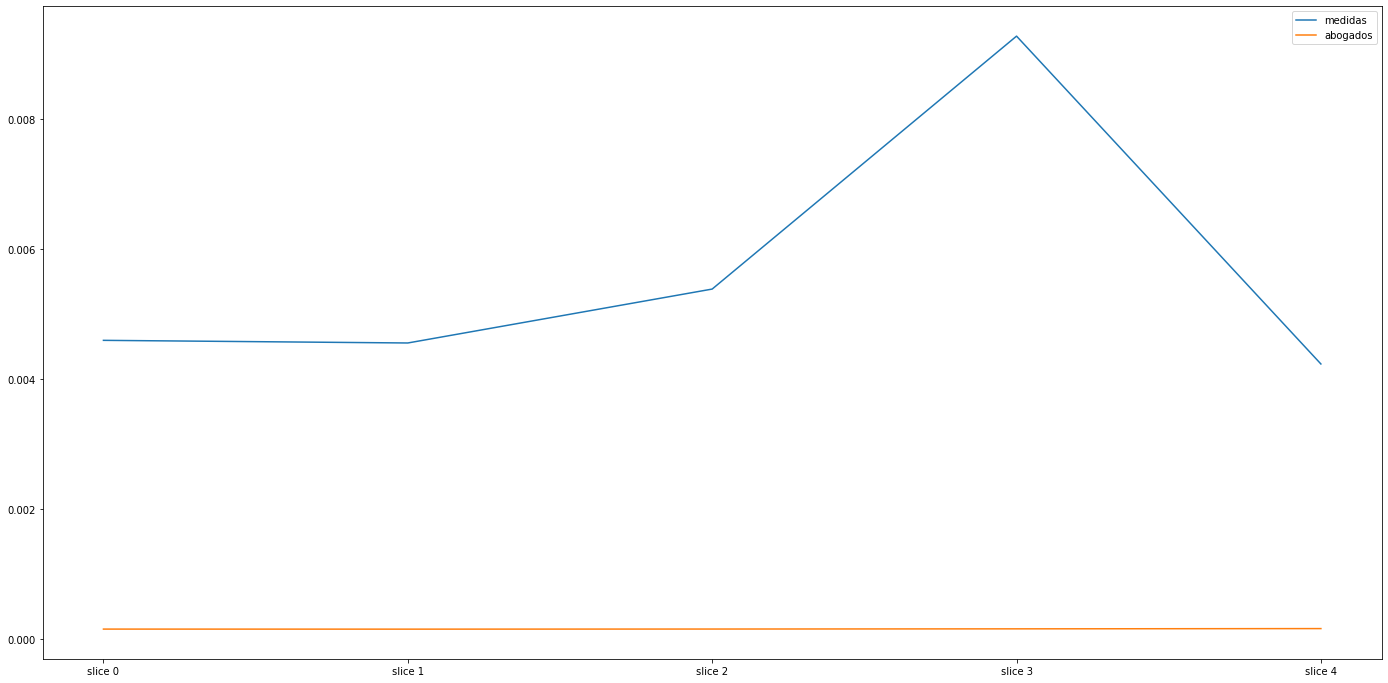

In [149]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

df=pd.DataFrame({'xvalues': xvalues1, 'yvalues': yvalues1 })
plt.plot( 'xvalues', 'yvalues', data=df, label="medidas")

df=pd.DataFrame({'xvalues': xvalues2, 'yvalues': yvalues2 })
plt.plot( 'xvalues', 'yvalues', data=df, label="abogados")

#df=pd.DataFrame({'xvalues': xvalues4, 'yvalues': yvalues4 })
#plt.plot( 'xvalues', 'yvalues', data=df, label="crisis")

#df=pd.DataFrame({'xvalues': xvalues5, 'yvalues': yvalues5 })
#plt.plot( 'xvalues', 'yvalues', data=df, label="proyecto")

ax.legend()
plt.show()

#### 5.2 Exploración de los tópicos

In [82]:
table=[]
for i in range(5):
    row=["slice "+str(i)]
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=35)
    for keyword in keywords:
        row.append(str(keyword[0])+", "+str(round(keyword[1],3)))
    table.append(row)

In [83]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

slice 0,"derechos, 0.018","humanos, 0.014","personas, 0.011","informe, 0.008","casos, 0.008","uso, 0.008","violaciones, 0.007","caso, 0.007","lugar, 0.007","octubre, 0.006","víctimas, 0.006","años, 0.006","manifestaciones, 0.005","violencia, 0.005","parte, 0.005","información, 0.005","comuna, 0.005","lesiones, 0.005","investigación, 0.005","delitos, 0.004","funcionarios, 0.004","respecto, 0.004","incendio, 0.004","momento, 0.004","delito, 0.004","manifestantes, 0.004","situación, 0.004","vida, 0.003","seguridad, 0.003","homicidio, 0.003","hechos, 0.003","país, 0.003","antecedentes, 0.003","acuerdo, 0.003","acción, 0.003"
slice 1,"personas, 0.013","$, 0.009","lugar, 0.007","comuna, 0.007","años, 0.007","octubre, 0.007","parte, 0.007","investigación, 0.006","funcionarios, 0.006","derechos, 0.006","personal, 0.005","momento, 0.005","antecedentes, 0.005","caso, 0.005","manifestaciones, 0.005","uso, 0.005","violaciones, 0.005","situación, 0.005","joven, 0.005","manifestantes, 0.005","incendio, 0.004","muerte, 0.004","casos, 0.004","información, 0.004","hecho, 0.004","humanos, 0.004","perdigones, 0.004","hechos, 0.004","embargo, 0.004","acuerdo, 0.004","carabineros, 0.003","manifestación, 0.003","calle, 0.003","violencia, 0.003","vida, 0.003"
slice 2,"personas, 0.016","parte, 0.008","octubre, 0.008","derechos, 0.007","manifestaciones, 0.007","funcionarios, 0.007","años, 0.006","información, 0.006","carabineros, 0.006","hecho, 0.005","situación, 0.005","investigación, 0.005","antecedentes, 0.005","hechos, 0.005","delito, 0.005","delitos, 0.005","joven, 0.004","familia, 0.004","comuna, 0.004","respecto, 0.004","caso, 0.004","violencia, 0.004","fiscal, 0.004","casos, 0.004","acuerdo, 0.004","interior, 0.004","autoridades, 0.004","denuncias, 0.004","violaciones, 0.004","momento, 0.004","querellas, 0.004","acciones, 0.004","país, 0.004","calle, 0.003","balines, 0.003"
slice 3,"personas, 0.017","años, 0.011","parte, 0.008","funcionarios, 0.007","vida, 0.007","derechos, 0.007","respecto, 0.006","antecedentes, 0.006","hecho, 0.005","hechos, 0.005","investigación, 0.005","comuna, 0.005","denuncias, 0.005","lesiones, 0.004","información, 0.004","fiscal, 0.004","momento, 0.004","delitos, 0.004","violencia, 0.004","autoridades, 0.004","caso, 0.004","delito, 0.004","manifestaciones, 0.004","situación, 0.004","acuerdo, 0.004","octubre, 0.004","familia, 0.004","uso, 0.004","personal, 0.004","persona, 0.004","cuenta, 0.004","organismo, 0.003","embargo, 0.003","días, 0.003","horas, 0.003"
slice 4,"años, 0.013","investigación, 0.013","familia, 0.011","fiscal, 0.01","delito, 0.01","parte, 0.008","antecedentes, 0.008","hecho, 0.007","delitos, 0.007","trabajo, 0.007","cuenta, 0.006","víctima, 0.006","personas, 0.006","respecto, 0.005","obesidad, 0.005","momento, 0.005","víctimas, 0.005","contra, 0.005","homicidio, 0.005","casa, 0.005","comuna, 0.005","casos, 0.005","lesiones, 0.004","vehículo, 0.004","caso, 0.004","justicia, 0.004","vida, 0.004","padre, 0.004","violencia, 0.004","información, 0.004","policía, 0.004","horas, 0.004","autoridades, 0.004","bala, 0.004","embargo, 0.004"


In [84]:
keyword="perdigones"
topic=1
xvalues1=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues1=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues1.append(newValue)

('perdigones', 0.001920706736095383)
('perdigones', 0.0036628701676456286)
('perdigones', 0.0034167390845980337)
('perdigones', 0.001431523359435553)
('perdigones', 0.0009550357847753437)


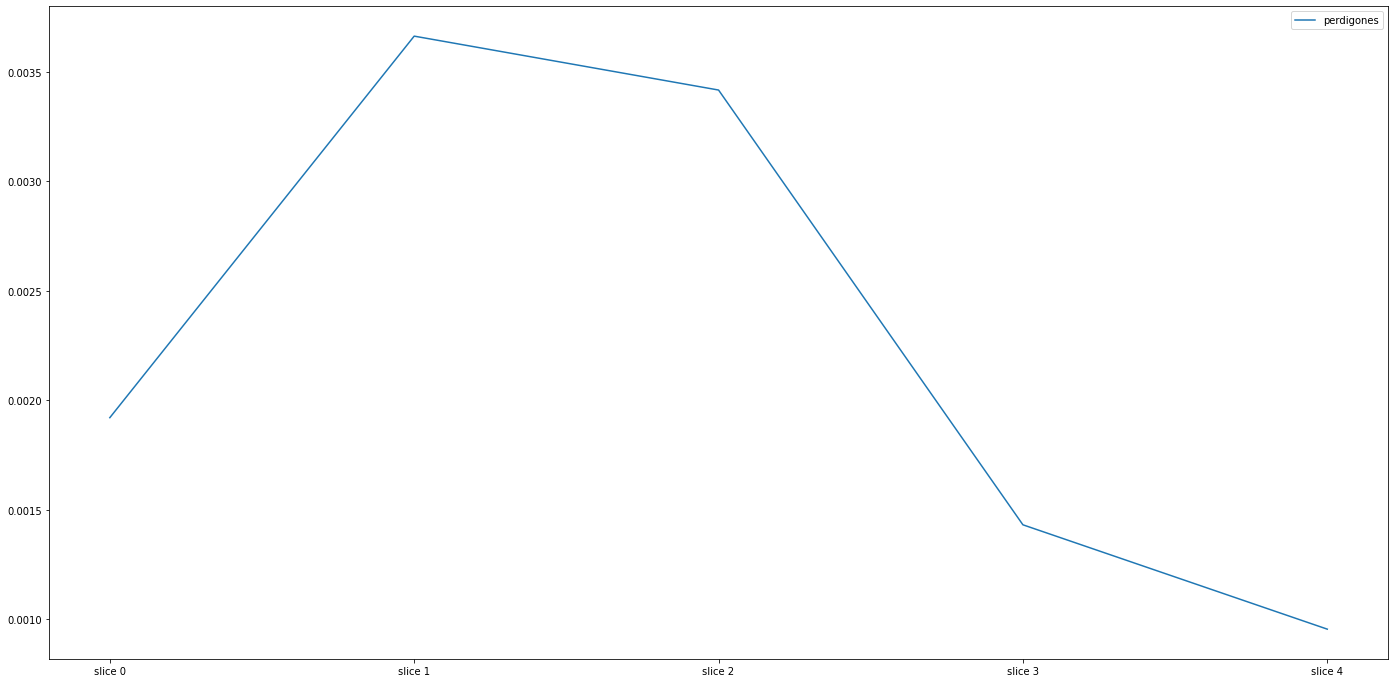

In [85]:
# libraries and data
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df=pd.DataFrame({'xvalues': xvalues1, 'yvalues': yvalues1 })
plt.plot( 'xvalues', 'yvalues', data=df, label="perdigones")

ax.legend()
plt.show()